## Cell-Finder 3000.1
Modified Cell Finder program originally created by Xuan Fang

Goal: Measure SERCA values of cells in CFP, GFP, and mCherry channels

In [10]:
import transients
import os
import sys
import skimage
import ipywidgets
import skimage.io
import numpy as np
from cellpose import models
from skimage import exposure
import matplotlib.pylab as plt
from matplotlib import rcParams

np.set_printoptions(threshold=sys.maxsize)

In [17]:
#file testing
from tkinter import filedialog

#tkinter.Tk().withdraw() # prevents an empty tkinter window from appearing

folder_path = filedialog.askdirectory()
folder_path += "/"

In [2]:
# sepcify image file path and names
# Marx
path = "E:/Loyola/PKH/Cell-Finder/Test_Data/Taylor/6-8/PLB/N1/"
# Mac
#path = "/Users/xfang/Desktop/projects/SERCA_modeling/data/SERCA"
fileNames = ["CFP.tif", "GFP.tif", "mCherry.tif"]
channelNames = ["CFP", "GFP", "MCHERRY"]

Code expects the time index to be the first entry. If this isn't the case, set timeReversed=True

In [3]:
class container():
  def __init__(self,fileName,
                    index = None,# none- single channel image; int otherwise
                    raw = None, # array of data; usually leave undefined 
                    mask = None # binary array of cells corresponding to img
                    ):
    self.fileName = fileName
    self.index = index
    self.raw = raw
    self.mask = mask
            
# Class for cell properties
class cellProp():
    def __init__(self, coords=None, area=None):
        self.coords = coords
        self.area = area

In [4]:
# create a dictionary to store channel info
channels = {}
for i, name in enumerate(channelNames):
    channel = container(fileNames[i], index=i)
    channels[name] = channel
    channels[name].channel_index = i

# references
CFP = channels['CFP']
GFP = channels['GFP']
MCHERRY = channels['MCHERRY']

In [11]:
# get raw data from images
for channel in channels.values():
  print("processing " + channel.fileName)

  if (channel == MCHERRY):
    ar = transients.LoadTimeData(path + channel.fileName, timeReversed = True)
  else:
    ar = transients.LoadStaticData(path + channel.fileName, timeReversed = True)
  
  channel.raw = np.asarray(ar)
  print()


processing CFP.tif
Returning an array of size (1608, 1608)

processing GFP.tif
Returning an array of size (1608, 1608)

processing mCherry.tif
Keeping 101 frames
Reversing time index
Returning an array of size (101, 1608, 1608)



In [13]:
# define cellpose model and run cellpose to find channel masks
model = models.Cellpose(gpu=True, model_type='cyto2')

for channel in channels.values():
    if (channel == MCHERRY):
        data = channel.raw[0, :, :]
    else:
        data = channel.raw[:, :]
    
    print("Processing mask for: " + channel.fileName)
    masks, flows, styles, diams = model.eval(data, diameter=None, do_3D=False, )
    channel.mask = masks

Processing mask for: CFP.tif
Processing mask for: GFP.tif
Processing mask for: mCherry.tif


In [14]:
# convert masks to binary format
for key, channel in channels.items():
    channel.binaryMask = np.zeros_like(channel.mask, int)
    channel.binaryMask[channel.mask > 0] = 1

In [15]:
# find cells only expressed in all three channels
comboMask = CFP.binaryMask + GFP.binaryMask + MCHERRY.binaryMask

finalBinaryMask = np.zeros_like(comboMask, int)
finalBinaryMask[comboMask == 3] = 1

dataSet = finalBinaryMask * MCHERRY.raw
cellCount = np.max(finalBinaryMask * MCHERRY.mask)

In [26]:
# get cell coordinates
indices=[]
areas=[]

for i in range(1, numOfCells+1):
    index = np.argwhere(MCHERRY.mask == i)
    area = len(index)
    indices.append(index)
    areas.append(area)

indices = np.array(indices, dtype=object)
areas = np.array(areas, dtype=object)

In [27]:
region_cells = []
for i in range(numOfCells):
    prop = cellProp(indices[i], areas[i])
    region_cells.append(prop)

MCHERRY.region_cells = region_cells

In [44]:
print(len(MCHERRY.region_cells))

258


In [28]:
# get time series data for selected cells in all three channels
traces, region_cells_MASTER = transients.GetTraces(
                dataSet,    # time-series data after masking 
                finalBinaryMask,  # mask
                region_cells = MCHERRY.region_cells, # region
                channelName = MCHERRY.index
                )

C:\Users\jakes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jakes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [29]:
# Normalize data
normalized = [None] * len(traces)

for i in range(len(traces)):
    trace = traces[i]
    minVal = np.min(trace)
    maxVal = np.max(trace)
    norm = (trace - minVal) / (maxVal - minVal)

    normalized[i] = norm

C:\Users\jakes\AppData\Local\Temp\ipykernel_6448\2836307723.py:8: RuntimeWarning: invalid value encountered in divide
  norm = (trace - minVal) / (maxVal - minVal)


In [31]:
from openpyxl import Workbook
filename = os.path.join(path + "test.xlsx")

transposed_traces = list(map(list, zip(*traces)))
transposed_norm = list(map(list, zip(*normalized)))
wb = Workbook()
sheet = wb.active

# Traces
for i, sublist in enumerate(transposed_traces):
    for j, item in enumerate(sublist):
        header = sheet.cell(row = 1, column = (j*4)+1)
        header.value = ("Cell " + str(j+1))

        cell = sheet.cell(row = i+2, column = (j*4)+1)
        cell.value = item

# Normalization
for i, sublist in enumerate(transposed_norm):
    for j, item in enumerate(sublist):
        header = sheet.cell(row = 1, column = (j*4)+2)
        header.value = ("Norm " + str(j+1))

        cell = sheet.cell(row = i+2, column = (j*4)+2)
        cell.value = item



destFile = os.path.join(path + "test.xlsx")
wb.save(destFile)

### Banished Code

In [1]:
temp = GFP.raw * GFP.binaryMask
print(temp[temp > 0])

NameError: name 'GFP' is not defined

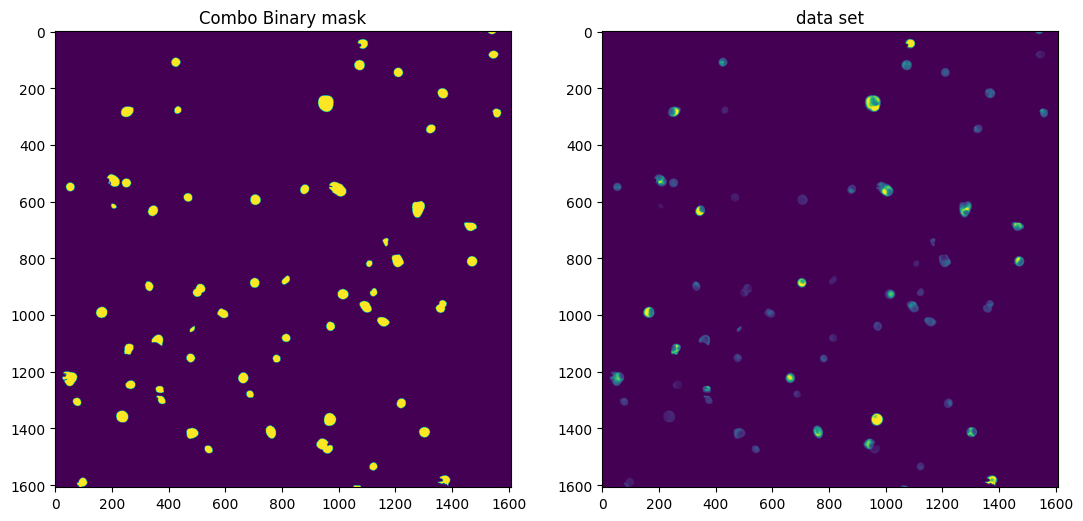

In [13]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(finalBinaryMask)
ax1.set_title('Combo Binary mask')
np.set_printoptions(threshold=sys.maxsize)

ax2 = plt.subplot(132)
ax2.set_title('data set')
ax2.imshow(dataSet[0])

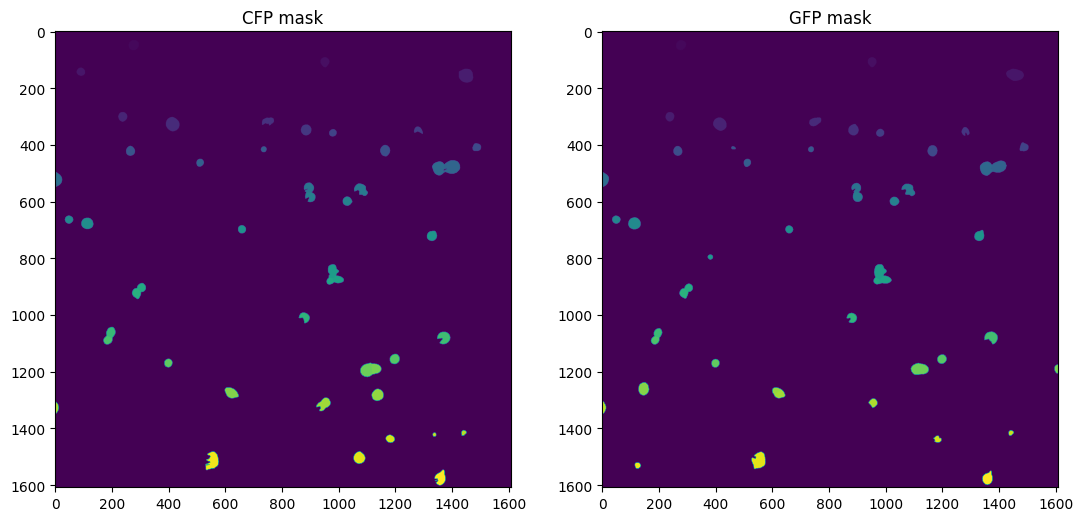

In [14]:
# skip
plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(CFP.mask)
ax1.set_title('CFP mask')
np.set_printoptions(threshold=sys.maxsize)

ax2 = plt.subplot(132)
ax2.set_title('GFP mask')
ax2.imshow(GFP.mask)

TypeError: only integer scalar arrays can be converted to a scalar index

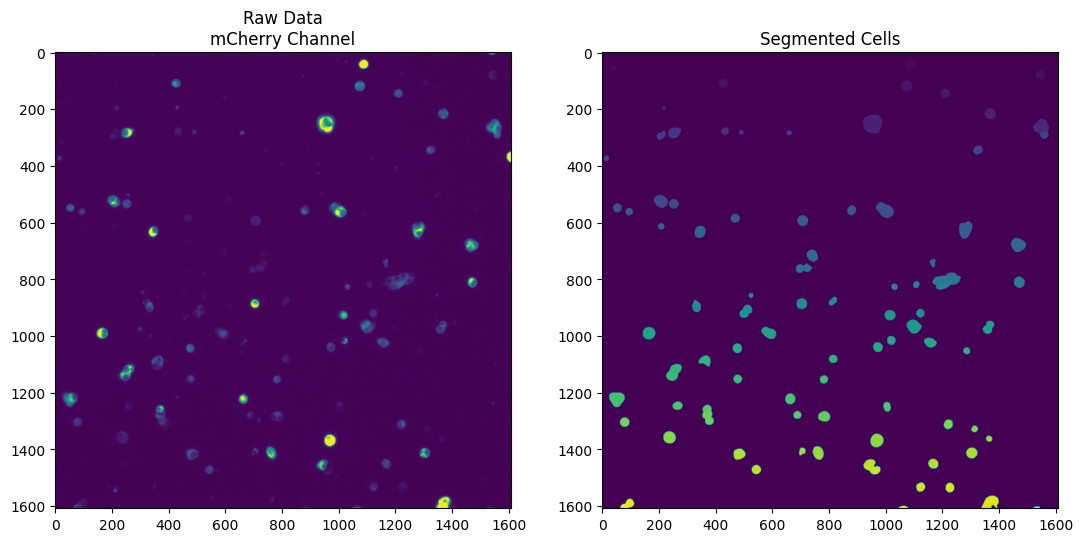

In [14]:
# skip
plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(MCHERRY.raw[0, :, :])
ax1.set_title('Raw Data\nmCherry Channel')
np.set_printoptions(threshold=sys.maxsize)

# plot cellposed data
ax2 = plt.subplot(132)
ax2.set_title('Segmented Cells')
ax2.imshow(MCHERRY.mask)

# label individual cells
labels=[]
for i in range(dataSet[0]):
    for j in range(dataSet[1]):
        if masks[i][j] == 0:
            continue
        else:
            if MCHERRY.mask[i][j] not in labels:
                labels.append(MCHERRY.mask[i][j])
                ax2.text(j, i, int(MCHERRY.mask[i][j])-1, ha="center", va="center", fontsize=10, fontweight='black', color='orange')

In [ ]:
# get coordinates for each cell
"""
numOfCells = np.max(maskTotal)
indices = []
areas = []

for i in range(1, numOfCells+1):
    index = np.argwhere(maskTotal == i)
    area = len(index)
    indices.append(index) 
    areas.append(area)

indices = np.array(indices, dtype=object)
areas = np.array(areas, dtype=object)
"""

In [ ]:
"""
allCells = np.zeros_like(MCHERRY.mask, int)
totalMask = np.zeros_like(MCHERRY.mask, int)
allCells = CFP.mask + GFP.mask + MCHERRY.mask
totalMask[allCells >= 1] = 1
"""

In [7]:
# convert masks to binary format
for key, channel in channels.items():
    channel.binaryMask = np.zeros_like(channel.mask, int)
    channel.binaryMask[channel.mask > 0] = 1

    """
    if (channel.fileName == MCHERRY.fileName):
        result = channel.raw * totalMask[None, :, :]
    else:
        result = channel.raw * totalMask[:, :]

    result[result >= 1] = 1
    channel.binaryMask = result
    """

In [8]:
comboMask = np.zeros_like(MCHERRY.mask, int)
comboMask = CFP.binaryMask + GFP.binaryMask + MCHERRY.binaryMask

finalMask = np.zeros_like(comboMask, int)
finalMask[comboMask == 3] = 1
dataSet = (finalMask * CFP.raw[:, :]) + (finalMask * GFP.raw[:, :]) + (finalMask * MCHERRY.raw)

In [54]:
expData = dataSet[dataSet > 0]
outputFileName = os.path.join(path + "foo.csv")
np.savetxt(outputFileName, expData, delimiter=',')

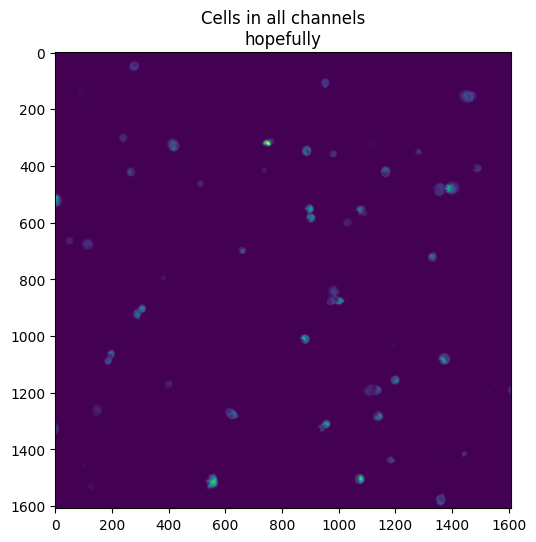

In [39]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(131)
ax1.imshow(dataSet)
ax1.set_title('Cells in all channels\nhopefully')
np.set_printoptions(threshold=sys.maxsize)

In [58]:
# store segmentation info as region_cells using cellProp object
numOfCells = np.max(dataSet)
region_cells = []
for i in range(numOfCells):
    prop = cellProp(indices[i], areas[i])
    region_cells.append(prop)

MCHERRY.region_cells = region_cells

TypeError: 'numpy.float64' object cannot be interpreted as an integer

### Isolate cells/record transients 
Gets transients for all cell-like objects (selection criteria come after this function) 


In [9]:
# get time series data for each cell in mCherry channel
traces, region_cells_MASTER = transients.GetTraces(
                dataSet, # time-series data after masking 
                MCHERRY.mask, # mask
                )

Detected 52 total cells.


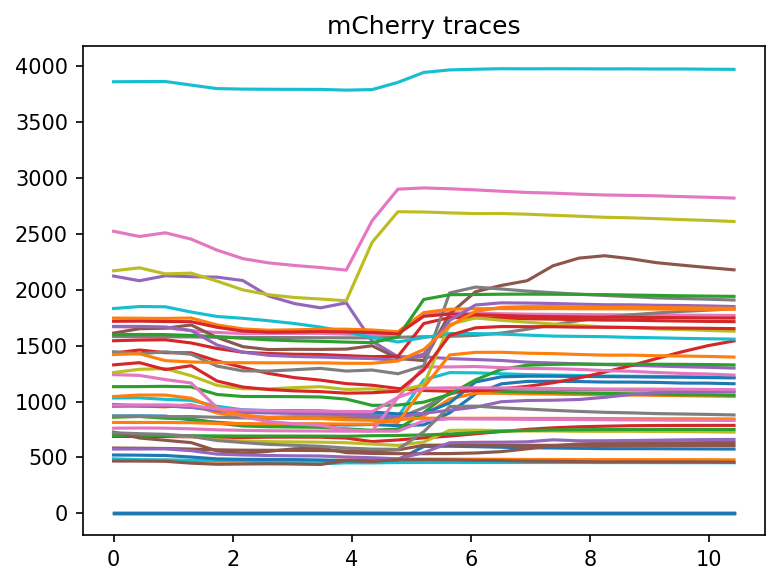

In [10]:
# get mCherry cell traces
normalization = []
nTrace = len(traces)
nTimePts = len(traces[0])
frameRate = 25 # sec/frame
ts = np.linspace(0, frameRate * nTimePts/60, nTimePts)
start = 0
end = 30

rcParams['figure.figsize'] = 10, 4
rcParams['figure.dpi'] = 150
fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.set_title('mCherry traces')
    
for j in range(nTrace):
    trace = traces[j]    
    ax.plot(ts[start:end+1], trace[start:end+1])
    
plt.tight_layout()
        

In [22]:
# Export data to different sheets per cell
import pandas as pd

outputFileName = os.path.join(path + "foo.xlsx")
# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(traces)

# Create a new Excel writer object
writer = pd.ExcelWriter(outputFileName, engine='xlsxwriter')

# Iterate over each list in the list of lists
for i, sublist in enumerate(traces):
    # Convert the sublist to a DataFrame
    sublist_df = pd.DataFrame(sublist)

    # Write the DataFrame to a new worksheet
    sublist_df.to_excel(writer, sheet_name=f'Sheet{i+1}', index=False)

# Save the Excel file
writer.close()

In [58]:
# Export data to same sheet, separated by column
from openpyxl import Workbook
from openpyxl.utils import get_column_letter

filename = os.path.join(path + "test.xlsx")
transposed_list = list(map(list, zip(*traces)))
workbook = Workbook()
sheet = workbook.active

# Iterate over each list in the list of lists
for row_index, sublist in enumerate(transposed_list):
    # Write each element of the sublist to a row

    for col_index, value in enumerate(sublist):
        # Calculate the column letter based on the index
        col_letter = get_column_letter((col_index * 2) + 1)

        # Write the value to the cell
        sheet[f'{col_letter}1'] = 'Cell Trace'
        sheet[f'{col_letter}{row_index+1}'] = value

    # Insert an empty column after each list
    empty_col_letter = get_column_letter((col_index * 2) + 2)
    sheet.insert_cols((col_index * 2) + 2)

# Save the workbook
workbook.save(filename)

In [ ]:
from openpyxl import Workbook
from openpyxl.utils import get_column_letter

workbook = Workbook(write_only=True)
sheet = workbook.create_sheet()

# Write column headings
sheet.append(list_of_lists)

# Write data
for sublist in list_of_lists:
    sheet.append(sublist)

# Save the workbook
workbook.save(filename)

In [ ]:
# Export data to same sheet, separated by column
from openpyxl import Workbook

wb = Workbook()
destFile = os.path.join(path + "test.xlsx")

for trace, data in zip(traces, dataSet):
    print(trace, data)

In [ ]:
# Export data to same sheet, separated by column
from openpyxl import Workbook

wb = Workbook()
destFile = os.path.join(path + "test.xlsx")
ws1 = wb.active
ws1.title = "Cell Traces"
dict={(40987, 'A'): [[1, 2, 3], [0, 1, 0], [0, 1, 1]], (11233, 'R'): [[2, 0, 2], [0, 2, 4]], (10716, 'R'): [[1, 1, 1]], (11049, 'S'): [[6, 0, 5], [2, 5, 7]]}
number = 1
for item in enumerate(traces):
    ws1.cell(row=number,column=1).value = item[0]
    ws1.cell(row=number, column=2).value = item[1]
    r=3

    for list in traces[item]:
        ws1.cell(row=number, column=r).value = str(list)
        r+=1

    number += 1
wb.save(filename = destFile)

In [ ]:
# save cell data to excel file
def dataToExcel(column, dataSet, name, path, transpose=False, save=False):
    destFile = os.path.join(path + "foo.xlsx")
    wb = Workbook()
    sheet = wb.active

    if (transpose == True):
        transposed_set = list(map(list, zip(*dataSet)))

    for i, sublist in enumerate(dataSet):
        for j, item in enumerate(sublist):
            header = sheet.cell(row = 1, column = (j*4)+column)
            header.value = (str(name) + str(j+1))

            cell = sheet.cell(row = i+2, column = (j*4)+column)
            cell.value = item

    if(save == True):
        destFile = os.path.join(path + "test.xlsx")
        wb.save(destFile)